# Binary Planet Suppression: Toy Model

In [1]:
from astropy.table import Table
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

mpl.rc('lines',linewidth = 1.5)
mpl.rc('font',size = 12)
mpl.rc('axes',labelsize = 14, linewidth=1.25)
mpl.rc('xtick',labelsize = 14)
mpl.rc('ytick',labelsize = 14)
# enable math fonts
mpl.rc('mathtext', default = 'regular')

import pickle

import pandas as pd

In [2]:
# define the radius valley
rad_valley = 1.7

### Data from Sullivan, Gaia/Bedell, KOIs, KIC

In [3]:
# read in Kendall's catalog, xmatched to all the stuff from Kepler that I need
with open('kendall+kepler.pkl', 'rb') as file:
       db = pickle.load(file)

# read in my kois table
with open('kois+gaia.pkl', 'rb') as file:
        kois = pd.read_pickle(file)

# remove the studied binaries from the all_KOI catalog
kois_less = kois[ (~kois['kepoi_name'].isin(db['kepoi_name'])) & \
                 (kois['koi_disposition']=='CONFIRMED') & \
                 np.isfinite(kois['parallax']) & \
                 (kois['ruwe']<1.2) ]

print('KOIs, all', len(kois[ (~kois['kepoi_name'].isin(db['kepoi_name'])) & \
                 (kois['koi_disposition']=='CONFIRMED')]) )
print('KOIs, singles', len(kois_less))
print('Binaries, all planets', len(db))
print('Binaries, unique stars', len(db['KOI'].unique()))

KOIs, all 2504
KOIs, singles 2404
Binaries, all planets 404
Binaries, unique stars 286


### CKS Sample

In [4]:
tmp = Table.read('fulton2018.vot')
cks = tmp.to_pandas()
cks['kepoi_name'] = cks['KOI']
cks['KOI'] = cks['kepoi_name'].str.extract(r'K0*(\d+)\.\d+')[0].astype(int)


### Optional limit on periods

In [5]:
period_limit = False

if period_limit:
    
    plim = (db['koi_period'] > 5) & (db['koi_period'] < 30)
    kplim = (kois_less['koi_period'] > 5) & (kois_less['koi_period'] < 30)
    cksplim = (cks['Per'] > 5) & (cks['Per'] < 30)
    
else:
    
    plim = db['koi_period'] < 100
    kplim = kois_less['koi_period'] < 100
    cksplim = cks['Per'] < 100


### Define subsamples

In [6]:
radius_limit = 4

good = (db['e_Rpkep']/db['Rpkep'] < 0.15) & plim & (db['Rpkep'] < radius_limit) & (db['Rpkep'] >=0.5)
close = db['SepAU']<200

kois_good = kois_less[(kois_less['koi_prad_err1']/kois_less['koi_prad'] < 0.15) & \
    (kois_less['koi_prad_err2']/kois_less['koi_prad'] < 0.15) 
                      & kplim & (kois_less['koi_prad']<radius_limit)
                     & (kois_less['koi_prad'] >= 0.5) ].copy()

cks_good = cks[(cks['E_Rp']/cks['Rp'] < 0.05) & (cks['e_Rp']/cks['Rp'] < 0.05) & \
               cksplim & (cks['Rp']<radius_limit) & (cks['Rp']>=0.5)].copy()


n_bin = len(db['Rppri'][good  & plim])
n_super_earths_bin = len(db['Rppri'][good  & plim & (db['Rppri']<rad_valley)])


In [7]:
print("Binaries, planets filtered", n_bin)
print("Binaries, unique stars filtered", len(db['KOI'][good & plim].unique()))
print("Binaries -- frac super-Earths: ", float(n_super_earths_bin)/float(n_bin), \
      np.sqrt(float(n_super_earths_bin))/float(n_bin))

print('Single KOIs, filtered', len(kois_good))
print('Single KOIs, unique stars filtered', len(kois_good['KOI'].unique()))
print("Single KOIs -- frac super-Earths: ", \
      float(len(kois_good[kois_good['koi_prad']<rad_valley]))/float(len(kois_good)), \
      np.sqrt(float(len(kois_good[kois_good['koi_prad']<rad_valley])))/float(len(kois_good)))

print('CKS, filtered', len(cks_good))
print('CKS, unique stars filtered', len(cks_good['KOI'].unique()))
print("CKS -- frac super-Earths: ", \
      float(len(cks_good[cks_good['Rp']<rad_valley]))/float(len(cks_good)), \
      np.sqrt(float(len(cks_good[cks_good['Rp']<rad_valley])))/float(len(cks_good)))


Binaries, planets filtered 195
Binaries, unique stars filtered 143
Binaries -- frac super-Earths:  0.5025641025641026 0.05076664070057264
Single KOIs, filtered 956
Single KOIs, unique stars filtered 622
Single KOIs -- frac super-Earths:  0.4131799163179916 0.020789337776518608
CKS, filtered 716
CKS, unique stars filtered 539
CKS -- frac super-Earths:  0.42877094972067037 0.024471250653540826


In [8]:
db['multiplanet_system?'] = db['KOI'].duplicated(keep=False)
cks_good['multiplanet_system?'] = cks_good['KOI'].duplicated(keep=False)
kois_good['multiplanet_system?'] = kois_good['KOI'].duplicated(keep=False)

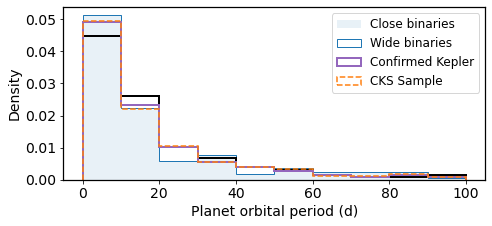

In [9]:
nbins = 10
histrange = (0,100)
fig, axes = plt.subplots(1, 1, figsize=(7,3.3), sharex=True, sharey=True)

# planets with good radii in binary systems with rho<100 au and planet period < 100 days
plt.hist(db['koi_period'][close], 
             range=histrange, bins=nbins, density=True, 
         histtype='stepfilled', color='C0', alpha=0.1,
        label='Close binaries')
plt.hist(db['koi_period'][close], 
             range=histrange, bins=nbins, density=True, 
             histtype='step', color='C0' , label='Wide binaries')

plt.hist(db['koi_period'][~close], 
             range=histrange, bins=nbins, density=True, 
             histtype='step', color='k', lw=2 )

# compared to the kois that are at least not definite binaries with good radii and per<100 days
plt.hist(kois_less['koi_period'], 
             range=histrange, bins=nbins, density=True, 
             histtype='step', lw=2, color='C4',
        label='Confirmed Kepler')

# compared to the cks
plt.hist(cks['Per'], 
             range=histrange, bins=nbins, density=True, 
             histtype='step',lw=1.5, linestyle='--', color='C1',
        label='CKS Sample')

plt.ylabel('Density')
plt.xlabel('Planet orbital period (d)')
plt.legend()
plt.tight_layout()
plt.savefig('periods.png')

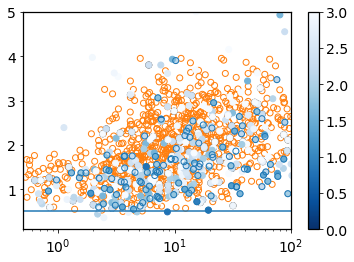

In [10]:
plt.scatter(kois_good['koi_period'], kois_good['koi_prad'],
         edgecolor='C1', lw=1, facecolor='None', label='Kepler')

plt.scatter(db['koi_period'][good & ~close], db['koi_prad'][good & ~close] ,
         edgecolor='k', facecolor='None', lw=1, label='Close binaries')
plt.scatter(db['koi_period'], db['koi_prad'], c = np.log10(db['SepAU']),vmin=0, vmax=3,
         cmap='Blues_r',  label='Close binaries')
plt.colorbar()
plt.scatter(db['koi_period'][good & close], db['koi_prad'][good & close] ,
         edgecolor='C0', lw=1, facecolor='None', label='Close binaries')


plt.xlim(0.5,100)
plt.ylim(0.1,5)
plt.axhline(0.5)
plt.xscale('log')

# Toy Model

next up I take the kois_less (kois with good params minus any that are binaries in kendall's list) and pretend every single star is actually a binary star with a separation drawn randomly from Kendall's sample's distribution of separations. Suppress the formation of > 2 Rearth planets using the suppression model and remake the histogram. Does it work?

In [11]:
def suppression_factor_simple(a_values):
    a_inner_true = 10  # AU (suppression 100%)
    a_outer_true = 200  # AU (suppression 0%)
    results = (np.log10(a_values) - np.log10(a_inner_true)) / (np.log10(a_outer_true) - np.log10(a_inner_true))
    return np.clip(results, a_min=0, a_max=1)

def suppression_factor(a_values):
    
    log_a = np.log10(np.asarray(a_values))
    
    log_points = np.array([np.log10(1), np.log10(10), np.log10(200)])
    S_points = np.array([0, 0.15, 1])
    
    S_val = np.interp(log_a, log_points, S_points)
    
    return np.clip(S_val, a_min=0, a_max=1)

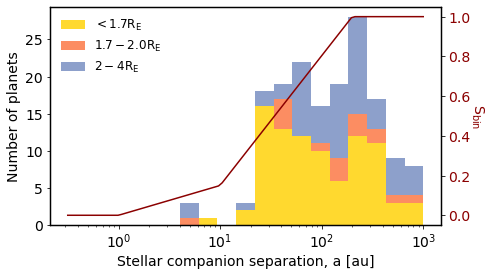

In [12]:
a_values = np.logspace(-0.5,3, 100)
S_values = suppression_factor(a_values)

fig, ax1 = plt.subplots(figsize=(7, 4))

bins = np.logspace(np.log10(a_values.min()), np.log10(a_values.max()), 20)

ses = db['SepAU'][good & plim & (db['Rppri']<=1.7)]
ppp = db['SepAU'][good & plim & (db['Rppri']>1.7) & (db['Rppri']<2) ]
mns = db['SepAU'][good & plim & (db['Rppri']>2) & (db['Rppri']<4) ]
ax1.hist([ses, ppp, mns], bins=bins,
         alpha=1, color=['#ffd92f','#fc8d62','#8da0cb'], 
         stacked = True, label=['$<1.7 R_E$', '$1.7 - 2.0 R_E$','$2-4 R_E$'])

ax1.set_xscale('log') # Set the x-axis to logarithmic scale
ax1.set_ylabel('Number of planets', color='k')
ax1.tick_params(axis='y', labelcolor='k')

ax1.set_xlabel('Stellar companion separation, a [au]')
plt.legend(edgecolor='None', facecolor='w')

ax2 = ax1.twinx()



ax2.plot(a_values, S_values, color='darkred', linestyle='-', label='Suppression Factor')
ax2.tick_params(axis='y', labelcolor='darkred')

ax2.set_ylabel('$S_\mathrm{bin}$', rotation=270, color='darkred', labelpad=15)
plt.xscale('log')
#plt.title('Suppression function from Moe & Kratter')
#plt.grid(True)
plt.tight_layout()
plt.savefig('overview.png')

In [98]:

def planet_simulation(suppression_cat, planets_cat, join_on='kepid', prad_col='koi_prad'):

    scat_copy = suppression_cat.copy()
    
    # Number of STARS in single KOIs catalog (not planets)
    n_stars = len(scat_copy)
    n_planets = len(planets_cat)

    # Randomly draw separations from db[close] for each star
    random_separations = np.random.choice(db[close]['SepAU'], size=n_stars, replace=True)
    # Add the jitter to the sampled values
    error_std = 0.1 * random_separations
    random_error = np.random.normal(loc=0.0, scale=error_std)
    random_separations = random_separations + random_error

    # Suppress planet formation (per STAR)
    scat_copy['my_factor'] = suppression_factor(random_separations)

    # Match STAR suppression to each PLANET
    realization = planets_cat.merge(scat_copy, on=join_on)
    realization['planet_exists'] = np.zeros(n_planets, dtype=bool) 

    # Condition 1: If Rp < 1.8, planet formation is not suppressed
    
    realization.loc[realization[prad_col] < rad_valley, 'planet_exists'] = True

    # Condition 2: If Rp >= 1.8, planet formation probabilistically suppressed
    
    mask = (realization[prad_col] >= rad_valley)
    random_vals = np.random.rand(n_planets)  # uniform random [0,1) to compare to my_factor
    realization.loc[mask, 'planet_exists'] = random_vals[mask] < realization['my_factor'][mask]

    planet_radius = realization.loc[realization['planet_exists'] == 1, prad_col].to_numpy()
    n_super_earths = len(planet_radius[planet_radius < rad_valley])
    
    obs = realization.loc[realization['planet_exists'] == 1].copy()
    obs['multiplanet_system?'] = obs[join_on].duplicated(keep=False)
     
    mtps = len((obs.loc[obs['multiplanet_system?'], join_on]).unique())
    stps = len((obs.loc[~obs['multiplanet_system?'], join_on]).unique())
    
    #print(obs[['kepoi_name', 'multiplanet_system?']][5:20])
    #print(realization[['kepoi_name', 'koi_prad', 'planet_exists']][5:20])
    
    return(planet_radius, float(n_super_earths)/float(len(planet_radius)), 
           float(mtps)/float(mtps+stps))



### Suppress the KOI sample

In [99]:
# define bins for recording plotting
histrange=[0.5,4]
nbins=13

bin_edges = np.linspace(histrange[0], histrange[1], nbins + 1)
bin_width = bin_edges[1] - bin_edges[0]
bin_center = bin_edges[:-1] + bin_width/2.

# List of unique KOI star names -- will be used to assign binaries to planetary systems
d = {'kepid': kois_good['kepid'].unique()}
suppression_cat = pd.DataFrame(data=d)

# run trials and save the results
ntrials = 1000
koi_sim_hist = np.ones((ntrials,len(bin_center)))
frac_SE_arr = np.ones(ntrials)
mtps_arr = np.ones(ntrials)
for i in range(ntrials):
    prad_sim_tmp, frac_SE_arr[i], mtps_arr[i] = planet_simulation(suppression_cat, kois_good, join_on='kepid', prad_col='koi_prad')
    hist, _ = np.histogram(prad_sim_tmp, 
            range=histrange, bins=nbins, density=True)
    koi_sim_hist[i] = hist
    


/var/folders/w8/c_s9_s9d6dx1kb0j3994pjvw0000gq/T/ipykernel_35240/1027181900.py:46: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.float(mtps)/np.float(mtps+stps))
/var/folders/w8/c_s9_s9d6dx1kb0j3994pjvw0000gq/T/ipykernel_35240/1027181900.py:46: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.float(mtps)/np.float(mtps+stps))
/var/folde

/var/folders/w8/c_s9_s9d6dx1kb0j3994pjvw0000gq/T/ipykernel_35240/1027181900.py:46: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.float(mtps)/np.float(mtps+stps))
/var/folders/w8/c_s9_s9d6dx1kb0j3994pjvw0000gq/T/ipykernel_35240/1027181900.py:46: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.float(mtps)/np.float(mtps+stps))
/var/folde

/var/folders/w8/c_s9_s9d6dx1kb0j3994pjvw0000gq/T/ipykernel_35240/1027181900.py:46: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.float(mtps)/np.float(mtps+stps))
/var/folders/w8/c_s9_s9d6dx1kb0j3994pjvw0000gq/T/ipykernel_35240/1027181900.py:46: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.float(mtps)/np.float(mtps+stps))
/var/folde

/var/folders/w8/c_s9_s9d6dx1kb0j3994pjvw0000gq/T/ipykernel_35240/1027181900.py:46: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.float(mtps)/np.float(mtps+stps))
/var/folders/w8/c_s9_s9d6dx1kb0j3994pjvw0000gq/T/ipykernel_35240/1027181900.py:46: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.float(mtps)/np.float(mtps+stps))
/var/folde

/var/folders/w8/c_s9_s9d6dx1kb0j3994pjvw0000gq/T/ipykernel_35240/1027181900.py:46: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.float(mtps)/np.float(mtps+stps))
/var/folders/w8/c_s9_s9d6dx1kb0j3994pjvw0000gq/T/ipykernel_35240/1027181900.py:46: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.float(mtps)/np.float(mtps+stps))
/var/folde

/var/folders/w8/c_s9_s9d6dx1kb0j3994pjvw0000gq/T/ipykernel_35240/1027181900.py:46: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.float(mtps)/np.float(mtps+stps))
/var/folders/w8/c_s9_s9d6dx1kb0j3994pjvw0000gq/T/ipykernel_35240/1027181900.py:46: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.float(mtps)/np.float(mtps+stps))
/var/folde

/var/folders/w8/c_s9_s9d6dx1kb0j3994pjvw0000gq/T/ipykernel_35240/1027181900.py:46: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.float(mtps)/np.float(mtps+stps))
/var/folders/w8/c_s9_s9d6dx1kb0j3994pjvw0000gq/T/ipykernel_35240/1027181900.py:46: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.float(mtps)/np.float(mtps+stps))
/var/folde

/var/folders/w8/c_s9_s9d6dx1kb0j3994pjvw0000gq/T/ipykernel_35240/1027181900.py:46: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.float(mtps)/np.float(mtps+stps))
/var/folders/w8/c_s9_s9d6dx1kb0j3994pjvw0000gq/T/ipykernel_35240/1027181900.py:46: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.float(mtps)/np.float(mtps+stps))
/var/folde

/var/folders/w8/c_s9_s9d6dx1kb0j3994pjvw0000gq/T/ipykernel_35240/1027181900.py:46: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.float(mtps)/np.float(mtps+stps))
/var/folders/w8/c_s9_s9d6dx1kb0j3994pjvw0000gq/T/ipykernel_35240/1027181900.py:46: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.float(mtps)/np.float(mtps+stps))
/var/folde

/var/folders/w8/c_s9_s9d6dx1kb0j3994pjvw0000gq/T/ipykernel_35240/1027181900.py:46: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.float(mtps)/np.float(mtps+stps))
/var/folders/w8/c_s9_s9d6dx1kb0j3994pjvw0000gq/T/ipykernel_35240/1027181900.py:46: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.float(mtps)/np.float(mtps+stps))
/var/folde

/var/folders/w8/c_s9_s9d6dx1kb0j3994pjvw0000gq/T/ipykernel_35240/1027181900.py:46: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.float(mtps)/np.float(mtps+stps))
/var/folders/w8/c_s9_s9d6dx1kb0j3994pjvw0000gq/T/ipykernel_35240/1027181900.py:46: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.float(mtps)/np.float(mtps+stps))
/var/folde

/var/folders/w8/c_s9_s9d6dx1kb0j3994pjvw0000gq/T/ipykernel_35240/1027181900.py:46: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.float(mtps)/np.float(mtps+stps))
/var/folders/w8/c_s9_s9d6dx1kb0j3994pjvw0000gq/T/ipykernel_35240/1027181900.py:46: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.float(mtps)/np.float(mtps+stps))
/var/folde

/var/folders/w8/c_s9_s9d6dx1kb0j3994pjvw0000gq/T/ipykernel_35240/1027181900.py:46: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.float(mtps)/np.float(mtps+stps))
/var/folders/w8/c_s9_s9d6dx1kb0j3994pjvw0000gq/T/ipykernel_35240/1027181900.py:46: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.float(mtps)/np.float(mtps+stps))
/var/folde

/var/folders/w8/c_s9_s9d6dx1kb0j3994pjvw0000gq/T/ipykernel_35240/1027181900.py:46: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.float(mtps)/np.float(mtps+stps))
/var/folders/w8/c_s9_s9d6dx1kb0j3994pjvw0000gq/T/ipykernel_35240/1027181900.py:46: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.float(mtps)/np.float(mtps+stps))
/var/folde

/var/folders/w8/c_s9_s9d6dx1kb0j3994pjvw0000gq/T/ipykernel_35240/1027181900.py:46: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.float(mtps)/np.float(mtps+stps))
/var/folders/w8/c_s9_s9d6dx1kb0j3994pjvw0000gq/T/ipykernel_35240/1027181900.py:46: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.float(mtps)/np.float(mtps+stps))
/var/folde

/var/folders/w8/c_s9_s9d6dx1kb0j3994pjvw0000gq/T/ipykernel_35240/1027181900.py:46: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.float(mtps)/np.float(mtps+stps))
/var/folders/w8/c_s9_s9d6dx1kb0j3994pjvw0000gq/T/ipykernel_35240/1027181900.py:46: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.float(mtps)/np.float(mtps+stps))
/var/folde

/var/folders/w8/c_s9_s9d6dx1kb0j3994pjvw0000gq/T/ipykernel_35240/1027181900.py:46: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.float(mtps)/np.float(mtps+stps))
/var/folders/w8/c_s9_s9d6dx1kb0j3994pjvw0000gq/T/ipykernel_35240/1027181900.py:46: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.float(mtps)/np.float(mtps+stps))
/var/folde

/var/folders/w8/c_s9_s9d6dx1kb0j3994pjvw0000gq/T/ipykernel_35240/1027181900.py:46: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.float(mtps)/np.float(mtps+stps))
/var/folders/w8/c_s9_s9d6dx1kb0j3994pjvw0000gq/T/ipykernel_35240/1027181900.py:46: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.float(mtps)/np.float(mtps+stps))
/var/folde

/var/folders/w8/c_s9_s9d6dx1kb0j3994pjvw0000gq/T/ipykernel_35240/1027181900.py:46: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.float(mtps)/np.float(mtps+stps))
/var/folders/w8/c_s9_s9d6dx1kb0j3994pjvw0000gq/T/ipykernel_35240/1027181900.py:46: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.float(mtps)/np.float(mtps+stps))
/var/folde

/var/folders/w8/c_s9_s9d6dx1kb0j3994pjvw0000gq/T/ipykernel_35240/1027181900.py:46: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.float(mtps)/np.float(mtps+stps))
/var/folders/w8/c_s9_s9d6dx1kb0j3994pjvw0000gq/T/ipykernel_35240/1027181900.py:46: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.float(mtps)/np.float(mtps+stps))
/var/folde

/var/folders/w8/c_s9_s9d6dx1kb0j3994pjvw0000gq/T/ipykernel_35240/1027181900.py:46: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.float(mtps)/np.float(mtps+stps))
/var/folders/w8/c_s9_s9d6dx1kb0j3994pjvw0000gq/T/ipykernel_35240/1027181900.py:46: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.float(mtps)/np.float(mtps+stps))
/var/folde

/var/folders/w8/c_s9_s9d6dx1kb0j3994pjvw0000gq/T/ipykernel_35240/1027181900.py:46: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.float(mtps)/np.float(mtps+stps))
/var/folders/w8/c_s9_s9d6dx1kb0j3994pjvw0000gq/T/ipykernel_35240/1027181900.py:46: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.float(mtps)/np.float(mtps+stps))
/var/folde

/var/folders/w8/c_s9_s9d6dx1kb0j3994pjvw0000gq/T/ipykernel_35240/1027181900.py:46: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.float(mtps)/np.float(mtps+stps))
/var/folders/w8/c_s9_s9d6dx1kb0j3994pjvw0000gq/T/ipykernel_35240/1027181900.py:46: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.float(mtps)/np.float(mtps+stps))
/var/folde

/var/folders/w8/c_s9_s9d6dx1kb0j3994pjvw0000gq/T/ipykernel_35240/1027181900.py:46: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.float(mtps)/np.float(mtps+stps))
/var/folders/w8/c_s9_s9d6dx1kb0j3994pjvw0000gq/T/ipykernel_35240/1027181900.py:46: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.float(mtps)/np.float(mtps+stps))
/var/folde

/var/folders/w8/c_s9_s9d6dx1kb0j3994pjvw0000gq/T/ipykernel_35240/1027181900.py:46: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.float(mtps)/np.float(mtps+stps))
/var/folders/w8/c_s9_s9d6dx1kb0j3994pjvw0000gq/T/ipykernel_35240/1027181900.py:46: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.float(mtps)/np.float(mtps+stps))
/var/folde

/var/folders/w8/c_s9_s9d6dx1kb0j3994pjvw0000gq/T/ipykernel_35240/1027181900.py:46: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.float(mtps)/np.float(mtps+stps))
/var/folders/w8/c_s9_s9d6dx1kb0j3994pjvw0000gq/T/ipykernel_35240/1027181900.py:46: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.float(mtps)/np.float(mtps+stps))
/var/folde

In [101]:
np.percentile(mtps_arr, q=(2.25,13.6,50,86.4, 98.75))

array([0.26746557, 0.27663551, 0.28862177, 0.29925651, 0.31149273])

In [15]:
low, koi_prad_sim, high = np.percentile(koi_sim_hist, q=(2.25,50,98.75), axis=0)
e_koi_prad_sim = (high-low)/2

koi_SE_frac = np.percentile(frac_SE_arr, q=(2.25,13.6,50,86.4, 98.75))

print(koi_SE_frac)

[0.49375    0.5        0.50836551 0.51701571 0.52596538]


### Suppress the CKS sample

In [16]:
# Holder for the random separations for the STARS
d = {'KOI': cks_good['KOI'].unique()}
suppression_cat = pd.DataFrame(data=d)

cks_sim_hist = np.ones((ntrials,len(bin_center)))
frac_SE_arr = np.ones(ntrials)
for i in range(ntrials):
    prad_sim_tmp, frac_SE_arr[i] = planet_simulation(suppression_cat, cks_good, join_on='KOI', prad_col='Rp')
    hist, _ = np.histogram(prad_sim_tmp, 
            range=histrange, bins=nbins, density=True)
    cks_sim_hist[i] = hist
    
low, cks_prad_sim, high = np.percentile(cks_sim_hist, q=(2.25,50,98.75), axis=0)
e_cks_prad_sim = (high-low)/2

cks_SE_frac = np.percentile(frac_SE_arr, q=(2.25,13.6, 50,86.4,98.75))

print(cks_SE_frac)

[0.50827815 0.51510067 0.52478632 0.53577661 0.54529307]


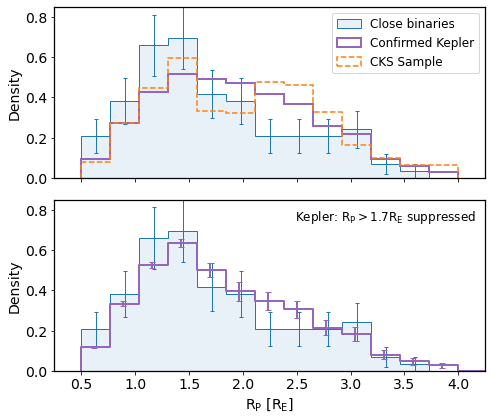

In [17]:
fig, axes = plt.subplots(2, 1, figsize=(7,6), sharex=True, sharey=True)

# planets with good radii in binary systems with rho<100 au and planet period < 100 days
y, _, _ = axes[0].hist(db['Rppri'][good & close & plim], 
             range=histrange, bins=nbins, density=True, 
         histtype='stepfilled', edgecolor='#1f77b4', facecolor='#e8f1f7',
        label='Close binaries')
n, _ = np.histogram(db['Rppri'][good & close & plim], 
             range=histrange, bins=nbins)

axes[0].errorbar(bin_center, y, np.sqrt(n)/np.sum(n)/bin_width, ls='None', lw=1, capsize=2, c='C0')


# compared to the kois that are at least not definite binaries with good radii and per<100 days
axes[0].hist(kois_good['koi_prad'], 
             range=histrange, bins=nbins, density=True, 
             histtype='step', lw=2, color='C4',
        label='Confirmed Kepler')

# compared to the cks
axes[0].hist(cks_good['Rp'], 
             range=histrange, bins=nbins, density=True, 
             histtype='step',lw=1.5, linestyle='--', color='C1',
        label='CKS Sample')

axes[0].set_ylabel('Density')
axes[0].legend()

if period_limit:
    axes[0].text(0.2,0.95, '$5<P_P(d)<30$')

# planets with good radii in binary systems with rho<100 au and planet period < 100 days
axes[1].hist(db['Rppri'][good & close & plim], 
             range=histrange, bins=nbins, density=True, 
             histtype='stepfilled',  edgecolor='#1f77b4', facecolor='#e8f1f7')
axes[1].errorbar(bin_center, y, np.sqrt(n)/np.sum(n)/bin_width, ls='None', lw=1, capsize=2, c='C0')


x = np.concatenate((bin_edges, [bin_edges[-1]+bin_width]))
y = np.concatenate(([0], koi_prad_sim, [0]))
plt.step(x, y, c='C4', lw=2)
y = np.concatenate(([0], cks_prad_sim, [0]))
plt.errorbar(bin_center-0.02, koi_prad_sim, e_koi_prad_sim, ls='None', lw=2, capsize=3, c='C4')
#plt.step(x, y, linestyle='--', c='C1', lw=1.5)
#plt.errorbar(bin_center+0.025, cks_prad_sim, e_cks_prad_sim, ls='None', lw=1.5, capsize=2, c='C1')

axes[1].text(0.98, 0.95, 'Kepler: $R_P>1.7 R_E$ suppressed ',
     horizontalalignment='right',
     verticalalignment='top',
     transform = axes[1].transAxes)

plt.xlim(0.25, 4.25)
plt.ylim(0,0.85)
plt.xlabel('$R_P$ [$R_E$]')
plt.ylabel('Density')
plt.tight_layout()
plt.savefig('suppression_sim-1p6Re.png')

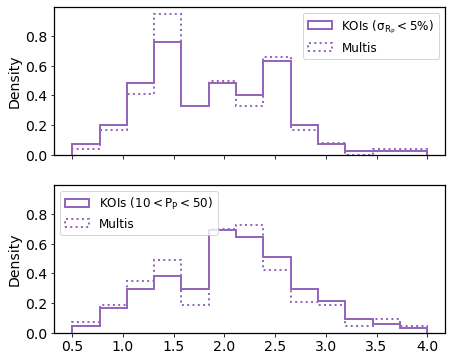

In [18]:
fig, axes = plt.subplots(2, 1, figsize=(7,6), sharex=True, sharey=True)

kois_subsample = kois_good[(kois_good['koi_prad_err1']/kois_good['koi_prad'] < 0.05) & \
    (kois_good['koi_prad_err2']/kois_good['koi_prad'] < 0.05)].copy()

# compared to the kois that are at least not definite binaries with good radii and per<100 days
axes[0].hist(kois_subsample['koi_prad'], 
             range=histrange, bins=nbins, density=True, 
             histtype='step', lw=2, color='C4',
        label=r'KOIs ($\sigma_{R_P}<5\%$)')

axes[0].hist(kois_subsample['koi_prad'][kois_subsample['multiplanet_system?']], 
             range=histrange, bins=nbins, density=True, 
             histtype='step', ls = ':', lw=2, color='C4',
        label='Multis')

axes[0].set_ylabel('Density')
axes[0].legend(loc='upper right')


kois_subsample = kois_good[(kois_good['koi_prad_err1']/kois_good['koi_prad'] < 0.1) & \
    (kois_good['koi_prad_err2']/kois_good['koi_prad'] < 0.1) & \
    (kois_good['koi_period'] < 50) & (kois_good['koi_period'] > 10)].copy()


# compared to the kois that are at least not definite binaries with good radii and per<100 days
axes[1].hist(kois_subsample['koi_prad'], 
             range=histrange, bins=nbins, density=True, 
             histtype='step', lw=2, color='C4',
        label='KOIs ($10<P_P<50$)')

axes[1].hist(kois_subsample['koi_prad'][kois_subsample['multiplanet_system?']], 
             range=histrange, bins=nbins, density=True, 
             histtype='step', ls = ':', lw=2, color='C4',
        label='Multis')

axes[1].set_ylabel('Density')
axes[1].legend(loc='upper left')

plt.savefig('multi_subsets.pdf')

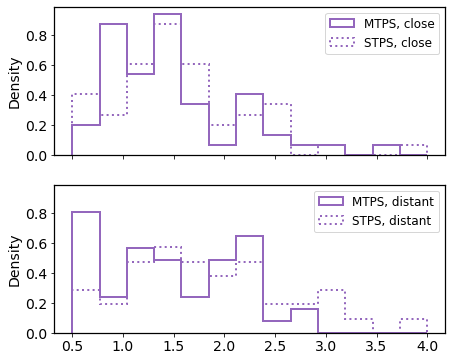

In [38]:
fig, axes = plt.subplots(2, 1, figsize=(7,6), sharex=True, sharey=True)

axes[0].hist(db['koi_prad'][db['multiplanet_system?'] & good & close], 
             range=histrange, bins=nbins, density=True, 
             histtype='step', lw=2, color='C4',
        label=r'MTPS, close')

axes[0].hist(db['koi_prad'][~db['multiplanet_system?'] & good & close], 
             range=histrange, bins=nbins, density=True, 
             histtype='step', lw=2,  ls = ':', color='C4',
        label=r'STPS, close')

axes[1].hist(db['koi_prad'][db['multiplanet_system?'] & good & ~close], 
             range=histrange, bins=nbins, density=True, 
             histtype='step', lw=2, color='C4',
        label='MTPS, distant')

axes[1].hist(db['koi_prad'][~db['multiplanet_system?'] & good & ~close], 
             range=histrange, bins=nbins, density=True, 
             histtype='step', ls = ':', lw=2, color='C4',
        label='STPS, distant')

for ax in axes:
    ax.set_ylabel('Density')
    ax.legend(loc='upper right')

In [30]:
stps = len(db['KOI'][~db['multiplanet_system?'] & good & ~close].unique())
mtps = len(db['KOI'][db['multiplanet_system?'] & good & ~close].unique())
print(mtps/(stps+mtps), np.sqrt(mtps)/(stps+mtps))

0.3709677419354839 0.07735212134375354


In [31]:
stps = len(db['KOI'][~db['multiplanet_system?'] & good & close].unique())
mtps = len(db['KOI'][db['multiplanet_system?'] & good & close].unique())
print(mtps/(stps+mtps), np.sqrt(mtps)/(stps+mtps))

0.32098765432098764 0.06295085819250351


In [87]:
stps = len(kois_good['KOI'][~kois_good['multiplanet_system?']].unique())
mtps = len(kois_good['KOI'][kois_good['multiplanet_system?']].unique())
print(mtps/(stps+mtps), np.sqrt(mtps)/(stps+mtps))

0.3279742765273312 0.022962792374735853


In [88]:
stps

418

In [89]:
mtps

204